In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
import matplotlib
%matplotlib inline
from scipy.ndimage import filters
from sklearn.cluster import KMeans

### Set parameters

In [25]:
imagePath = "/Users/Lu/Desktop/SMD/Data/2014 May/Pig 1/1stDay_Pig1_MSI/1stday/1a_burn_24_TIFF/Images/2014-05-20_11.05.13/"
N_theta=4; # number of rotations
N_freq=3; # number of frequencies
N_shrink=5; # shrink image dim to (1/N_shrink)*(1/N_shrink)

### Visulize kernels in an array

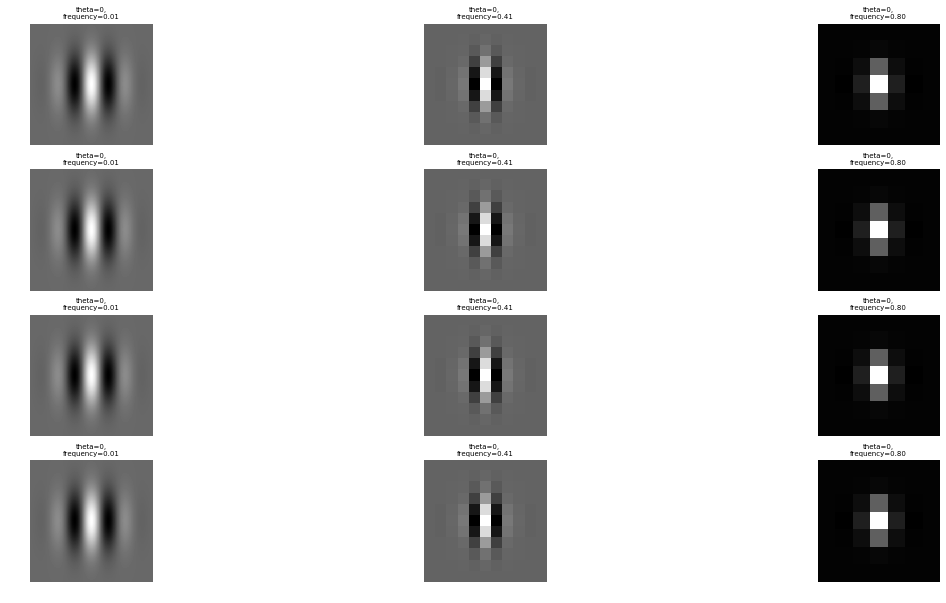

In [3]:
kernels = []
kernel_params = []
for theta in range(N_theta):
    theta = theta / N_theta* np.pi
    for frequency in np.linspace(0.01,0.8,N_freq,endpoint=True):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        kernels.append(kernel)

fig, axes = plt.subplots(nrows=N_theta, ncols=N_freq, figsize=(20, 10))
plt.gray()
for label, kernel, ax_row in zip(np.array(kernel_params).reshape(N_theta,N_freq), np.array(kernels).reshape(N_theta,N_freq), axes):
    # Plot Gabor kernel
    for lab, ker, ax in zip(label, kernel, ax_row):
        ax.imshow(np.real(ker), interpolation='nearest')
        ax.set_title(lab, fontsize=7)
        ax.axis('off')

plt.show()

### Load 8 MSI images

In [13]:
### Set directory to image file location
import os
import glob
os.chdir(imagePath)

from PIL import Image
#im=[]
#for i in range(8):
#    im=im.append("*F{}*".format(i))
im=["*F{}*".format(i) for i in range(1,9)]   

shrink = (slice(0, None, N_shrink), slice(0, None, N_shrink)) # down sample by 10

#F=[]
#for i in im:
#    F.append(img_as_float(data.load(imagePath+glob.glob(i)[0]))[shrink]) #F size 8*1044*1408
F=[img_as_float(data.load(imagePath+glob.glob(i)[0]))[shrink] for i in im]

image_names =["F{}".format(i) for i in range(1,9)]  
N_row=F[1].shape[0]
N_col=F[1].shape[1]

### Mutiply kernel with MSI images

In [5]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = [] # save both filtered output and kernel
kernel_params = []
Ffiltered=[]
sigma=[]
#gbfiltered=[] # just same the filtered output
for theta in range(N_theta):
    theta = theta / N_theta * np.pi
    for frequency in np.linspace(0.1,1,3,endpoint=True):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(im, kernel) for im in F]))
        #gbfiltered.append([power(im, kernel) for im in F]) 
        Ffiltered.append([power(im, kernel) for im in F])   # F=12*8*L*W
        # http://www.mathworks.com/help/images/texture-segmentation-using-gabor-filters.html?refresh=true
        sigma.append(3*0.5*1/frequency) # all the frequency values # length(12)
                                      # sigma for gaussian filter=3*0.5*wavelength (wavelength=1/freq)

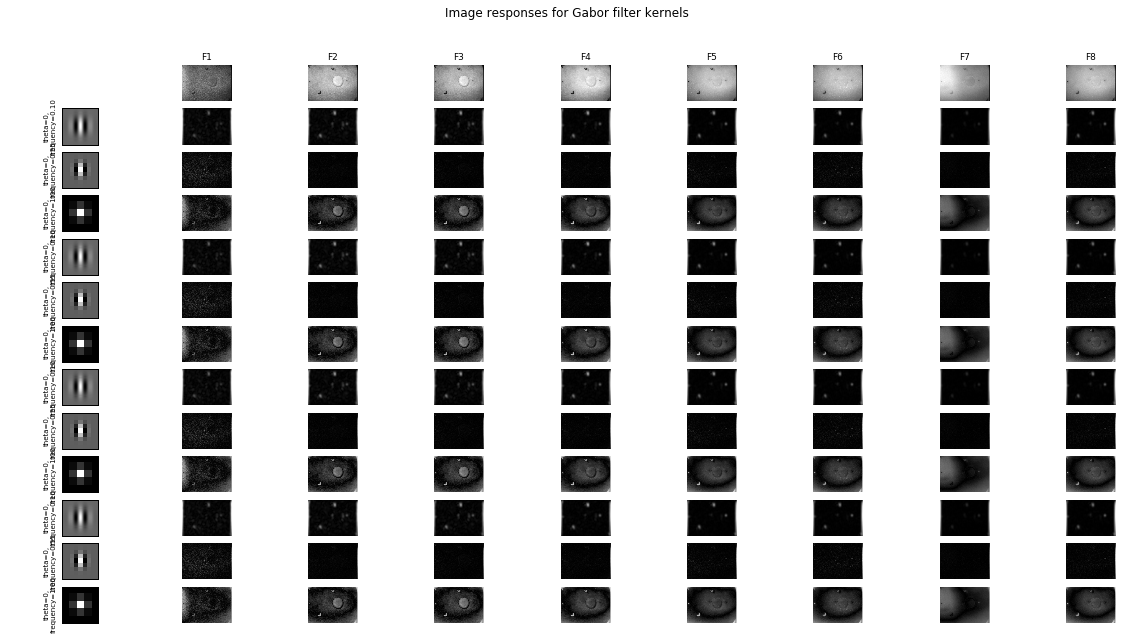

In [6]:
fig, axes = plt.subplots(nrows=N_theta*N_freq+1, ncols=9, figsize=(20, 10))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')
# Plot original images
for label, img, ax in zip(image_names, F, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

### Gabor filter 8 MSI images

In [7]:
# #F1filtered=[]
# Ffiltered=[]
# sigma=[]
# for theta in range(4):
#     theta = theta / 4. * np.pi
#     for frequency in np.linspace(0.1,1,3,endpoint=True):
#         kernel = gabor_kernel(frequency, theta=theta)
#         params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
#         kernel_params.append(params)
#         # Save kernel and the power image for each image
#         #F1filtered.append(power(F[0], kernel)) #12*L*W
#         Ffiltered.append([power(im, kernel) for im in F])   # F=12*8*L*W
#         # http://www.mathworks.com/help/images/texture-segmentation-using-gabor-filters.html?refresh=true
#         sigma.append(3*0.5*1/frequency) # all the frequency values # length(12)
#                                       # sigma for gaussian filter=3*0.5*wavelength (wavelength=1/freq)

### Gaussian smoothing gabor filtered MSI

In [8]:
# one MSI
# GFil_1=[] #12*L*W
# for im,sig in zip(F1filtered,sigma):
#     GFil_1.append(filters.gaussian_filter(im,sig))
# plt.imshow(GFil_1[0])
# plt.show()

In [23]:
# 8 MSI, this method is different to reshape for features
# GFil=[[] for _ in range(8)]#8*12*L*W
# for i in range(8) :
#     for j,sig in zip(range(12),sigma):
#         GFil[i].append(filters.gaussian_filter(Ffiltered[j][i],sig)) #
# # plt.imshow(GFil[0][0])
# # plt.show()

In [10]:
GFil_vec=[]#(8*12)*L*W
for i in range(8) :
    for j,sig in zip(range(N_theta*N_freq),sigma):
        GFil_vec.append(filters.gaussian_filter(Ffiltered[j][i],sig)) #96*L*W

### Combine features

In [21]:
# one MSI
# GFil_1=np.array(GFil_1)
# GFil_1=GFil_1.reshape(12,-1) # reshape to vector
# GFil_1=GFil_1.transpose()
# GFil_1.shape

In [16]:
features=[]
for i in range(8*N_theta*N_freq):
    features.append(np.array(GFil_vec[i]).reshape(1,N_row*N_col))# reshape to vector 1*(L*W)
features=np.array(features).transpose() #(L*W)*(12*8)
features=np.squeeze(features)

### Kmeans

In [22]:
# one MSI
# est =KMeans(n_clusters=6)
# est.fit(GFil_1)
# #est.fit(np.array(GFil[0]).reshape(12,-1).transpose())
# labels = est.labels_
#GFil_1.shape=(14805, 12)

In [18]:
est =KMeans(n_clusters=6)
est.fit(features[:,:])
labels = est.labels_

### Plot classes

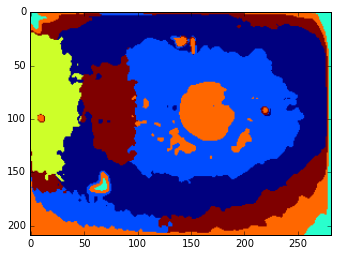

In [24]:
labels = labels.reshape(N_row,N_col)
_=plt.imshow(labels,cmap='jet')

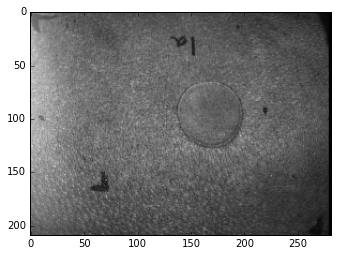

In [20]:
_=plt.imshow(F[0])